In [137]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [138]:
def gaussian(x, mean, std_dev):
    return np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

def initialize_centers(data, num_centers):
    kmeans = KMeans(n_clusters=num_centers, random_state=0)
    kmeans.fit(data)
    centers = kmeans.cluster_centers_
    std_devs = np.zeros(num_centers)
    for i in range(num_centers):
        std_devs[i] = np.std(data[np.where(kmeans.labels_ == i)])
    return centers, std_devs, kmeans.labels_

class RBFNetwork:
    def __init__(self, num_rbf, learning_rate):
        self.num_rbf = num_rbf
        self.learning_rate = learning_rate
        self.centers = None
        self.std_devs = None
        self.weights = None
        self.bias = None
        self.labels = None

    def fit(self, X, y):
        self.centers, self.std_devs, self.labels = initialize_centers(X, self.num_rbf)
        # Initialize weights and bias randomly
        self.weights = np.random.randn(self.num_rbf)
        self.bias = np.random.randn()

    def rbf(self, x, c, s):
        return gaussian(x, c, s)

    def predict(self, X):
        predictions = []
        for x in X:
            rbf_outputs = np.array([self.rbf(x, c, s) for c, s in zip(self.centers, self.std_devs)])
            predictions.append(np.dot(rbf_outputs.reshape(-1,), self.weights.reshape(-1,)) + self.bias)
        return np.array(predictions)

    def train(self, X, y, epochs=100):
        for epoch in range(epochs):
            for i in range(X.shape[0]):
                # Forward pass
                rbf_outputs = np.array([self.rbf(X[i], c, s) for c, s in zip(self.centers, self.std_devs)])
                predicted_output = np.dot(rbf_outputs.reshape(-1,), self.weights.reshape(-1,)) + self.bias
                loss = (predicted_output - y[i][0]) ** 2

                # Backward pass
                error = predicted_output - y[i][0]
                self.weights -= (self.learning_rate * error * rbf_outputs).reshape(-1,)
                self.bias -= self.learning_rate * error
            if epoch%50 == 0:
                print(f'Epoch {epoch}, Sample {i}, Loss: {loss:.4f}')

In [139]:
# Plot K-means clustering results
def plot_kmeans_clustering(X, centers, kmeans_labels):
    plt.scatter(X, np.zeros_like(X), c=kmeans_labels, cmap='viridis', label='Clustered Data')
    plt.scatter(centers, np.zeros_like(centers), color='red', s=100, marker='x', label='Centers')
    plt.title("K-means Clustering of RBF Centers")
    plt.xlabel("X")
    plt.legend()
    plt.show()

Epoch 0, Sample 99, Loss: 0.3519
Epoch 50, Sample 99, Loss: 0.0706
Epoch 100, Sample 99, Loss: 0.0607
Epoch 150, Sample 99, Loss: 0.0579


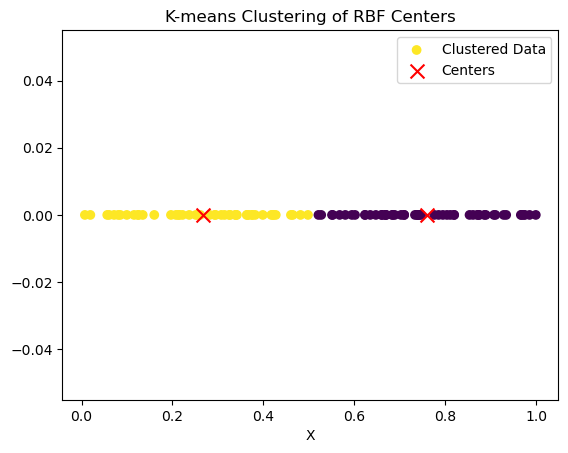

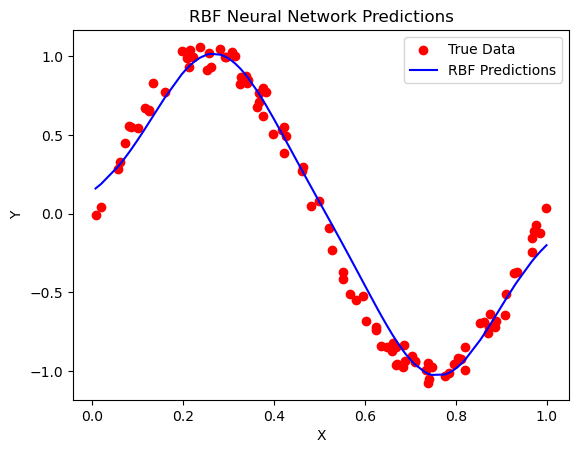

In [140]:
# Generate synthetic test data
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
Y = np.sin(2 * np.pi * X) + noise

# Reshape X and Y for the model
X = X.reshape(-1, 1)  # Reshape X to be a 2D array for the RBF network
Y = Y.reshape(-1, 1)  # Reshape Y for consistency

# Initialize and train the RBF network
num_rbf = 2
learning_rate = 0.01

rbf_network = RBFNetwork(num_rbf=num_rbf, learning_rate=learning_rate)
rbf_network.fit(X, Y)
rbf_network.train(X, Y, epochs=200)

# After fitting the RBF network, plot the clustering result
plot_kmeans_clustering(X, rbf_network.centers, rbf_network.labels)

# Test predictions
predictions = rbf_network.predict(X)

# Plotting results
import matplotlib.pyplot as plt

plt.scatter(X, Y, color='red', label='True Data')
plt.plot(X, predictions, color='blue', label='RBF Predictions')
plt.legend()
plt.title("RBF Neural Network Predictions")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()